In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk

dataset_path = "/workspaces/Implementation-of-Neural-Machine-Translation-of-Rare-Words-with-Subword-Units-on-Azerbaijani/data_source"
ds = load_from_disk(dataset_path=dataset_path)

In [18]:
from sklearn.model_selection import train_test_split

raw_data = ds["train"].to_pandas()
X = raw_data["partial_text"].map(lambda text: text.lower())
y = raw_data["gold_ending"].map(lambda text: text.lower())

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/0.9, random_state=42)


X_train_val.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

y_train_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)

In [19]:
from collections import Counter
from itertools import compress

In [20]:
special_token = "</spc>"
word_end_token = "<end>"
num_token = "</num>"

train_val_text =' '.join(X_train_val)
initial_character_set = list(set(train_val_text))

non_alpha_num_ch = list(map(lambda ch: not ch.isalnum(), initial_character_set))
alpha_ch = list(map(lambda ch: ch.isalpha(), initial_character_set))
num_ch = list(map(lambda ch: ch.isnumeric(), initial_character_set))

non_alpha_nums = list(compress(initial_character_set, non_alpha_num_ch))
non_alpha_nums.remove(" ")
alphas = list(compress(initial_character_set, alpha_ch))
numerics = list(compress(initial_character_set, num_ch))

for ch in non_alpha_nums:
    train_val_text = train_val_text.replace(ch, f' {special_token}{ch} ')

for ch in alphas:
    train_val_text = train_val_text.replace(ch+" ", f'{ch}{word_end_token} ')

for ch in numerics:
    train_val_text = train_val_text.replace(ch, f' {ch}{num_token} ')

initial_character_set = alphas

#### Let's code BPE right now

In [21]:
import re, collections 

def get_stats(vocab): 
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items(): 
        symbols = word.split()
        for i in range(len(symbols)-1): 
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs 

def merge_vocab(pair, v_in): 
    v_out = {} 
    total_tokens = 0
    bigram = re.escape(' '.join(pair)) 
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)') 
    for word in v_in: 
        w_out = p.sub(''.join(pair), word) 
        v_out[w_out] = v_in[word] 
        total_tokens += len(w_out.split())
    return v_out, total_tokens

vocab = Counter(train_val_text.split(" "))
vocab.pop('', None)
def word_split(word):
    if "<end>" in word:
        return " ".join(list(word[:word.find("<end>")]) + ["<end>"])
    elif special_token in word:
        return word
    elif num_token in word:
        return word
    else: return " ".join(list(word))

vocab = {word_split(k): v for k, v in vocab.items()}
print(f"Before Tokenization -> ", len(vocab.keys()))
print(vocab)
num_merges = 100
merge_numbers = []
token_counts = []
for i in range(num_merges): 
    try:
        pairs = get_stats(vocab) 
        best = max(pairs, key=pairs.get) 
        vocab, cnt = merge_vocab(best, vocab)
        merge_numbers.append(i)
        token_counts.append(cnt) 
    except: pass

Before Tokenization ->  22506
{'b u <end>': 1149, 'a d <end>': 11, 'd ü n y a n ı n <end>': 13, 'ə n <end>': 133, 'm ə ş h u r <end>': 12, 'a d l a r ı n d a n <end>': 1, 'b i r i d i r <end>': 7, '</spc>,': 9357, 'p u a r o <end>': 67, 'd ə r i n d ə n <end>': 8, 'n ə f ə s <end>': 20, 'a l d ı <end>': 20, 'v ə <end>': 1559, 'ə l l ə r i n i <end>': 29, 's i n ə s i n d ə <end>': 5, 'ç a r p a z l a d ı <end>': 2, '</spc>.': 8230, 'y ü z <end>': 31, 'i y i r m i <end>': 20, 'y e d d i n c i <end>': 2, 's ö z <end>': 49, '</spc>–': 1289, '</spc>“': 144, 'h ö k u m ə t <end>': 2, '</spc>”': 125, 't i l l s t o n a <end>': 1, 'd a <end>': 743, 'e y n i <end>': 76, 't a p ş ı r ı ğ ı <end>': 5, 'v e r i b l ə r <end>': 2, 'd e y ə <end>': 128, 'ç ı ğ ı r ğ a n <end>': 12, 'd ı r n a ğ ı <end>': 2, 'i l ə <end>': 453, 'g ö z <end>': 39, 'y a ş l a r ı n ı <end>': 3, 's i l ə r ə k <end>': 1, 'd a n ı ş ı r d ı <end>': 18, 's o n r a <end>': 366, 'i s ə <end>': 345, 'f ə l a k ə t <end>': 1

In [22]:
print(f"After Tokenization -> ", len(vocab.keys()))

After Tokenization ->  22506


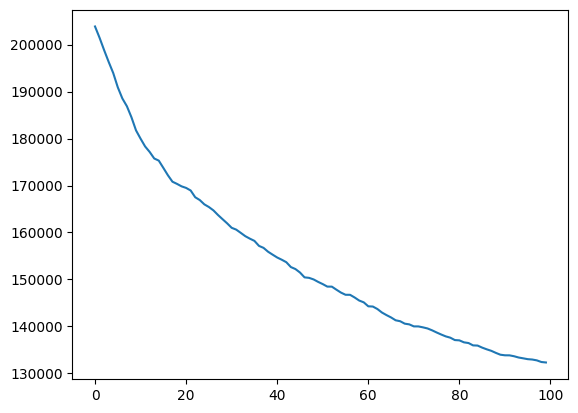

In [23]:
plt.plot(merge_numbers, token_counts)
plt.show()

In [24]:
token_vocabulary = []
for token_combo in vocab: 
    token_vocabulary += token_combo.split()

In [25]:
def tokenize_sentence(sentence):
    sentence = sentence.lower()
    for ch in non_alpha_nums:
        sentence = sentence.replace(ch, f' {special_token}{ch} ')
    for ch in alphas:
        sentence = sentence.replace(ch+" ", f'{ch}{word_end_token} ')
    for ch in numerics:
        sentence = sentence.replace(ch, f' {ch}{num_token} ')
    merged_sentence = " ".join(sentence.split())
    # for vocabulary_key in token_vocabulary.keys():
    #     while vocabulary_key in merged_sentence:
    #         merged_sentence[merged_sentence.find(vocabulary_key):merged_sentence.find(vocabulary_key)+len(vocabulary_key)]
    #         merged_sentence = merged_sentence[:merged_sentence.find(vocabulary_key)] + "[" + str(token_vocabulary) + "]" + merged_sentence[merged_sentence.find(vocabulary_key)+len(vocabulary_key):]
    return merged_sentence
sample_sentence = "Bürc Xəlifə hal-hazırda 111 dünyada ən hündür göydələndir"
sample_sentence, tokenize_sentence(sample_sentence)

('Bürc Xəlifə hal-hazırda 111 dünyada ən hündür göydələndir',
 'bürc<end> xəlifə<end> hal<end> </spc>- hazırda<end> 1</num> 1</num> 1</num> dünyada<end> ən<end> hündür<end> göydələndir')

In [26]:
from spacy.vocab import Vocab
spacy_vocab = Vocab(strings=token_vocabulary)

In [ ]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(spacy_vocab)

In [34]:
tokenizer(tokenize_sentence(sample_sentence))[0].text

'bürc<end>'

In [81]:
sample = tokenize_sentence(sample_sentence)
tokenizer(sample)

bu<end> qorxu<end> </spc>, 1</num> şüurun<end> bütün<end> dəlillərinə<end> baxmayaraq<end> </spc>, 1</num> 2</num> 3</num> adətən<end> </spc>, getgedə<end> daha<end> da<end> artır<end> </spc>, belə<end> ki<end> </spc>, 0</num> 0</num> 0</num> əql<end> bu<end> anda<end> bəlkə<end> də<end> daha<end> aydınlıq<end> kəsb<end> etsə<end> də<end> </spc>, bu<end> qorxu<end> hissinə<end> qarşı<end> durmaq<end> imkanından<end> məhrum<end> olur<end> </spc>.